# Fashion Recommendation System Implementation Demo

This notebook demonstrates how our recommendation system work as an integrated pipeline. We also illustrates our hyper-parameter tuning process, evaluation results and comparison between different methods in this notebook.

**Notebook Structure**

1. Image and text feature / similarity pre-computation for content-based recommendations

2. Load dataset and prepare for cross validation

3. Demonstration of hyper-parameters tuning for models

4. Hybrid recommendations with different methods

5. Evaluation results visualization and analysis

**Implementation Details**

- Methods implementation: `recommender/recall`

- Data filtering: `recommender/utils/data.py`

- Evaluation helper functions: `recommender/utils/evaluate.py`

- Image feature extraction: `scripts/dino_v2.py`

- Cross Validation data split: `scripts/data_split`

- Attempts to integration with larger system (incomplete): `recommender/recommender.py`

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import faiss
from matplotlib import pyplot as plt

from recommender.utils.data import (
    filter_transactions,
    filter_nan_age
)

from recommender.recall import (
    ContentBased,
    Item2VecModel,
    popularity_recall,
    postal_code_recall,
    product_code_recall,
    bought_together_recall,
    user_collaborative_recall,
    age_group_recall
)

from recommender.utils.evaluate import (
    compute_metrics,
    compare_recommendations,
    visualize_compare_recommendations
)

# Resource Paths

In [ ]:
# Pre-computed image and text feature vector for each item
image_feature_path = "./feature/dino_image_emb.npy"
text_feature_path = "./feature/glove_text_emb.npy"

# Content-based similarity cache directory
cb_cache_dir = "./feature"

# Items, users, and splited purchase history dataset paths
article_path = "./dataset/articles.csv"
customer_path = "./dataset/customers.csv"
fold_split_data_path = "./dataset/split"

# [1] Image & Text Content-Based Pre-Computations 

In [3]:
# Computing most similar items for each item, with image and text feature
content_based = ContentBased(
    image_feature_path=image_feature_path,
    text_feature_path=text_feature_path,
    feature_cache_dir=cb_cache_dir
)

# [2] Dataset Loading, Split and Filtering

In [4]:
# Load item data
articles = pd.read_csv(article_path)

# Load user data
customers = pd.read_csv(customer_path)

# Load transcation data, splitted according to time
fold_data = {}
for _fold in os.listdir(fold_split_data_path):
    if "fold" in _fold:
        fold_data[_fold] = (
            pd.read_csv(os.path.join(fold_split_data_path, _fold, "train.csv")),
            pd.read_csv(os.path.join(fold_split_data_path, _fold, "test.csv"))
        )

# [3] Hyper-Parameters Tuning

We tuned hyper-paramters for 2 collaborative filtering methods: Matrix Factorization and Item2Vec. Due to the computation resources and time limitation, we tuned on only one fold data to select best hyper-paramters.

We applied a greedy grid search tuning strategies. For each hyper-paramter, we fix all other parameters as default, and tune the target one. We selected the best value for each hyper-parameters one-by-one. 

In [5]:
recall_top_n = 100

In [6]:
# Use one-fold to tune hyper-parameters for quick development
train_df, test_df = fold_data['fold_3']
train_df = content_based.filter_content(train_df, articles)
train_df = filter_nan_age(train_df, customers)
test_df = filter_nan_age(test_df, customers)

train, (loyal_user_test, regular_user_test, few_purchase_test, new_user_test) = filter_transactions(train_df, test_df, verbose=True)
test = pd.concat([regular_user_test, few_purchase_test, new_user_test])

Condition 1 - Description: Users purchased more than 30 items in training set and more than 10 in testing set
Condition 1 - Train: 1141 users, 60466 transactions, 13710 articles
Condition 1 - Test: 1141 users, 21374 transactions, 6915 articles

Condition 2 - Description: Users purchased more than 5 items but less than 20 items in training set and more than 10 in testing set
Condition 2 - Train: 2459 users, 28762 transactions, 9761 articles
Condition 2 - Test: 2459 users, 38085 transactions, 9403 articles

Condition 3 - Description: Users made less than 5 purchases in training set but more than 10 purchases in testing set
Condition 3 - Train: 1055 users, 2585 transactions, 1948 articles
Condition 3 - Test: 1055 users, 16542 transactions, 6030 articles

Condition 4 - Description: Users did not make any purchase in training set, but purchased more than 10 items in testing set
Condition 4 - Train: 0 users, 0 transactions, 0 articles
Condition 4 - Test: 1856 users, 30674 transactions, 8195 

### Matrix Factorization Hyper-parameters tuning

We tuned 3 hyper-parameters for matrix factorization:

1. factors: latent feature size for users and items

2. alpha: weights to positive samples

3. iterations: training iterations. A larger iteration can provide better fit to data.

In [7]:
test_sets = pd.concat([loyal_user_test, regular_user_test])

mf_grid_search = {
    "factors": [25, 50, 75, 100, 125, 150],
    "alpha": [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    "iterations": [15, 30, 45, 60, 75]
}

mf_hparams_res = {}
for k, options in mf_grid_search.items():
    mf_hparams_res[k] = {}
    for opt in options:
        user_cf_res = user_collaborative_recall(
            train=train,
            top_N=recall_top_n,
            model_cfg={k: opt, 'random_state': 42}
        )
        mf_hparams_res[k][opt] = compute_metrics(user_cf_res, test_sets, recall_top_n)

Start matrix factorization:


100%|██████████| 15/15 [00:00<00:00, 18.81it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00, 14.45it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00, 10.41it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  7.99it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:02<00:00,  5.91it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  9.15it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  8.10it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  8.78it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  7.86it/s]


Start matrix factorization:


100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Start matrix factorization:


100%|██████████| 30/30 [00:03<00:00,  9.03it/s]


Start matrix factorization:


100%|██████████| 45/45 [00:04<00:00,  9.43it/s]


Start matrix factorization:


100%|██████████| 60/60 [00:07<00:00,  8.14it/s]


Start matrix factorization:


100%|██████████| 75/75 [00:09<00:00,  7.59it/s]


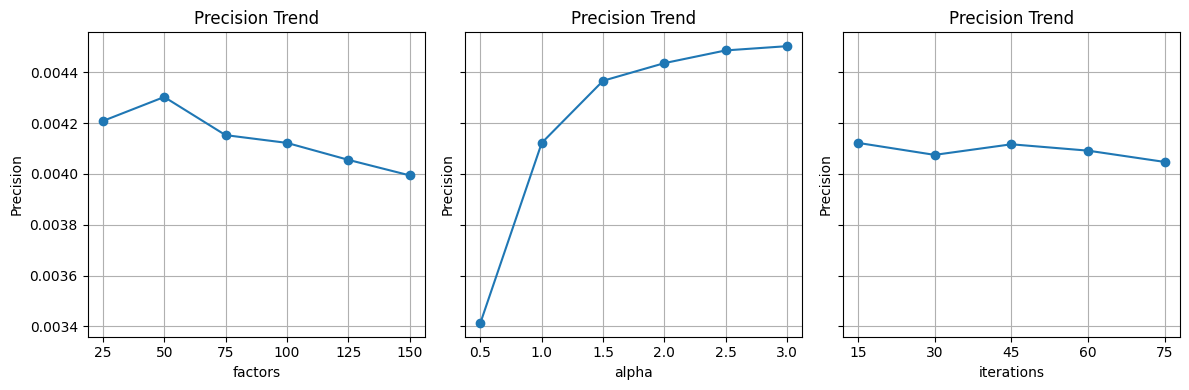

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, (k, hparams_res) in enumerate(mf_hparams_res.items()):
    # Extracting keys and precision values
    keys = list(hparams_res.keys())
    precision_values = [hparams_res[key]['precision'] for key in keys]

    ax = axs[i]
    ax.plot(keys, precision_values, marker='o', linestyle='-')
    ax.set_title('Precision Trend')
    ax.set_xlabel(f'{k}')
    ax.set_ylabel('Precision')
    ax.grid(True)
    ax.set_xticks(keys)  # Ensure all keys are marked on x-axis

plt.tight_layout()
plt.show()

### Item2Vec Hyper-parameters tuning

We tuned 4 hyper-parameters for item2vec model:

- vector_size: feature size for items

- sample: threshold for configuring which higher-frequency words are randomly downsampled

- negative: negative sampling number

- epochs: number of training iterations

In [9]:
test_sets = pd.concat([loyal_user_test, regular_user_test])

i2v_default = {
    "window": 9999,
    "seed": 42,
}
i2v_grid_search = {
    "vector_size": [50, 100, 150, 200, 250],
    "sample": [1.e-2, 1.e-3, 1.e-4, 1.e-5],
    "epochs": [5, 10, 15, 20, 25],
    "negative": [1, 5, 10, 15, 20]
}

i2v_hparams_pop_res = {}
i2v_hparams_sim_res = {}

for k, options in i2v_grid_search.items():
    i2v_hparams_pop_res[k] = {}
    i2v_hparams_sim_res[k] = {}
    for opt in options:
        cfg = i2v_default.copy()
        cfg.update({k: opt})
        i2v_model = Item2VecModel(
            train=train,
            top_N=recall_top_n,
            articles=articles,
            model_cfg=cfg
        )
        i2v_hparams_pop_res[k][opt] = compute_metrics(i2v_model.cluster_recall(), test_sets, recall_top_n)
        i2v_hparams_sim_res[k][opt] = compute_metrics(i2v_model.similarity_recall(), test_sets, recall_top_n)

item2vec similarity computation (cpu): 100%|██████████| 4632/4632 [00:00<00:00, 5341.08it/s]


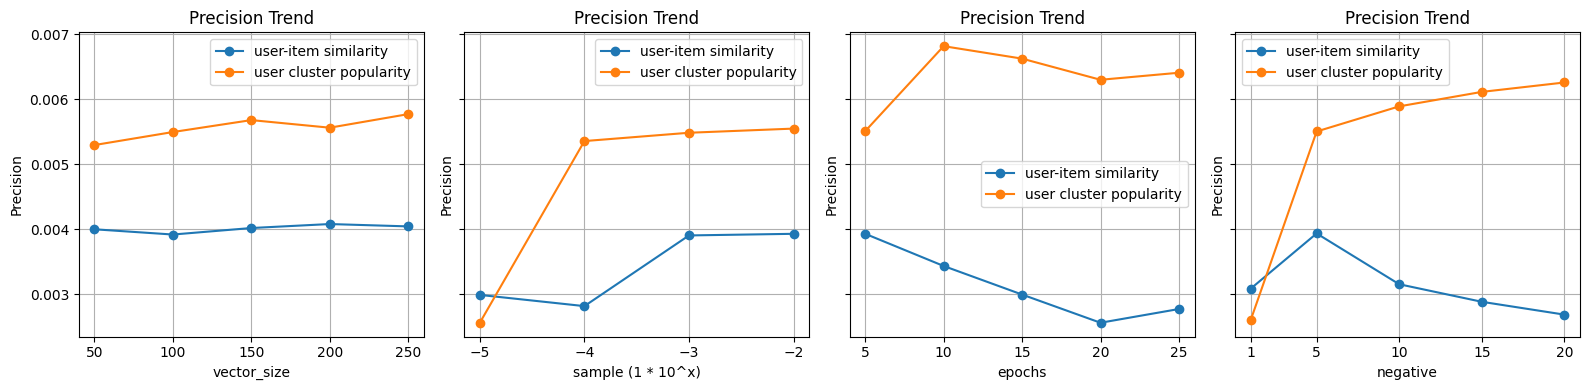

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, k in enumerate(i2v_hparams_sim_res):
    # Extracting keys and precision values
    keys = list(i2v_hparams_sim_res[k].keys())
    sim_precision_values = [i2v_hparams_sim_res[k][key]['precision'] for key in keys]
    pop_precision_values = [i2v_hparams_pop_res[k][key]['precision'] for key in keys]

    if k == "sample":
        keys = [np.log10(opt) for opt in keys]
        k = "sample (1 * 10^x)"
    ax = axs[i]
    ax.plot(keys, sim_precision_values, marker='o', linestyle='-', label="user-item similarity")
    ax.plot(keys, pop_precision_values, marker='o', linestyle='-', label="user cluster popularity")
    ax.set_title('Precision Trend')
    ax.set_xlabel(f'{k}')
    ax.set_ylabel('Precision')
    ax.grid(True)
    ax.set_xticks(keys)  # Ensure all keys are marked on x-axis
    ax.legend()
    
plt.tight_layout()
plt.show()

# [3] Fold Cross Validation

### Candidates generation (100,000 -> 1000) and Aggregation (1000 -> 12) Functions

We implemented the following candidates generation (recall) pipelines:

**recommender/recall/content_based.py**

- `ContentBased.recommend_items`: image/text content-based recommendations.

**recommender/recall/matrix_factorization.py**

- `Item2VecModel.cluster_recall`: popular items with in user clusters. Clustering was performed with trained Item2VecModel.

- `Item2VecModel.similarity_recall`: most similar items with user's profile. User profile was built based on trained Item2VecModel.

- `user_collaborative_recall`: Standard matrix factorization and collaborative filtering.

**recommender/recall/statistical.py**

- `popularity_recall`: Sort and recommend according to purchase counts in training period (popularity).

- `postal_code_recall`: Sort and recommend according to popularity, within items in users' region

- `product_code_recall`: Sort and recommend according to popularity, within items in user purchased product_code.

- `bought_together_recall`: Sort and recommend according to popularity, within bought together items of users' purchase history

- `age_group_recall`: Sort and recommend according to popularity, within items in users' age group

Please refer to our reports and implementations for more details.

In [11]:
import itertools

class Aggregate:
    """
    Aggregate results from each candidates generation (recall) pipeline
    """
    def __init__(self, recommend):
        self.recommend = recommend
        self.aggregate_recommend = {}

    def register_recall(self, customer_id, purchased, all_items, recall_pipes: dict):
        res = {}
        # initialize recall dict for all items
        for item in all_items:
            res[item] = {}
            for k in recall_pipes:
                res[item][k] = 0
                res[item][f"{k}_score"] = 0.0
                res[item]['purchased'] = int(item in purchased)
                res[item]['customer_id'] = customer_id
                res[item]['article_id'] = item

        for k in recall_pipes:
            recalled_num = len(recall_pipes[k])
            for i, item in enumerate(recall_pipes[k]):
                res[item][k] = 1
                res[item][f"{k}_score"] = (recalled_num - i) / recalled_num

        self.aggregate_recommend[customer_id] = res

    def aggregate(self, test_set, train, keys, top_n: int):
        purchase_dict = test_set.groupby('customer_id')['article_id'].agg(list)

        print(len(set(train['customer_id'])))
        test_users = set(train['customer_id']).intersection(list(purchase_dict.keys()))
        print(len(set(test_users)))
        for cid in tqdm(test_users, desc="Aggregrating recall results"):
            purchased = purchase_dict[cid]

            _res = {k: self.recommend[k][cid][:top_n] for k in keys}

            together_recall = set(itertools.chain(*_res.values()))
            
            self.register_recall(
                customer_id=cid,
                purchased=purchased,
                all_items=together_recall,
                recall_pipes=_res
            )

def average_score(agg: Aggregate, key_sets: dict):
    def agg_score_sort(item, keys):
        return sum([item[f"{k}_score"] for k in keys])

    key_sets_recommend = {}
    for k, keys in key_sets.items():
        key_sets_recommend[k] = {}
        for cid, candidates in tqdm(agg.aggregate_recommend.items(), desc=f"aggregating with {keys}"):
            key_sets_recommend[k][cid] = list(dict(sorted(candidates.items(), key=lambda x: agg_score_sort(x[1], keys), reverse=True)).keys())

    return key_sets_recommend

In [12]:
def prepare_recommendations(train: pd.DataFrame, test_set: pd.DataFrame, new_user_test: pd.DataFrame, recall_top_n=100):
    """
    The main function to make recommendations for each user.

    Recommend to existing users based on their purchase history, and new users based on their age and postal-code (region)
    """
    img_euclidean_recommend = content_based.recommend_items(train, media="image", dist="euclidean", N=recall_top_n)
    img_cosine_recommend = content_based.recommend_items(train, media="image", dist="cosine", N=recall_top_n)
    txt_euclidean_recommend = content_based.recommend_items(train, media="text", dist="euclidean", N=recall_top_n)
    txt_cosine_recommend = content_based.recommend_items(train, media="text", dist="cosine", N=recall_top_n)

    purchase_count = popularity_recall(train=train)

    popularity_all = {
        cid: purchase_count['article_id']
        for cid in train['customer_id'].unique()
    }

    product_code_res = product_code_recall(
        train=train,
        articles=articles,
        purchase_count=purchase_count
    )

    product_code_recommend = {
        cid: product_code_res[cid]['article_id']
        for cid in train['customer_id'].unique()
    }
        
    postal_code_res, customers_postal_code_map = postal_code_recall(
        train=train,
        customers=customers,
        purchase_count=purchase_count
    )

    postal_code_recommend = {
        cid: list(postal_code_res[customers_postal_code_map[cid]][:recall_top_n]['article_id'])
        for cid in train['customer_id'].unique()
    }

    age_group_res, customers_age_group_map = age_group_recall(
        train=train,
        customers=customers,
        purchase_count=purchase_count
    )

    age_group_recommend = {
        cid: list(age_group_res[customers_age_group_map[cid]][:recall_top_n]['article_id'])
        for cid in train['customer_id'].unique()
    }

    bought_together_res = bought_together_recall(train=train)
    bought_together_recommend = {
        cid: bought_together_res[cid]['article_id']
        for cid in train['customer_id'].unique()
    }
    
    user_cf_recommend = user_collaborative_recall(
        train=train,
        top_N=recall_top_n,
        model_cfg={
            'factors': 50,
            'alpha': 2.5,
            'iterations': 15,
            'random_state': 42
        }
    )

    item2vec = Item2VecModel(
        train=train,
        articles=articles,
        top_N=recall_top_n,
        model_cfg={
            "window": 9999,
            "seed": 42,
            "vector_size": 100,
            "sample": 1.e-3,
            "epochs": 10,
            "negative": 5
        }
    )

    item2vec_cls_recommend = item2vec.cluster_recall()
    item2vec_sim_recommend = item2vec.similarity_recall()

    _recommend = {
        'img_euclidean': img_euclidean_recommend,
        'img_cosine': img_cosine_recommend,
        'txt_euclidean': txt_euclidean_recommend,
        'txt_cosine': txt_cosine_recommend,
        'popularity_all': popularity_all,
        'product_code': product_code_recommend,
        'postal_code': postal_code_recommend,
        'age_group': age_group_recommend,
        'bought_together': bought_together_recommend,
        'user_cf': user_cf_recommend,
        'item2vec_cls_res': item2vec_cls_recommend,
        'item2vec_sim_res': item2vec_sim_recommend,
    }

    agg = Aggregate(_recommend)
    agg.aggregate(
        test_set=test_set,
        train=train,
        keys=list(_recommend.keys()),
        top_n=recall_top_n
    )

    key_sets = {
        'Aggregation (1)': ['txt_euclidean', 'postal_code', 'item2vec_cls_res'],
        'Aggregation (2)': ['txt_euclidean', 'img_euclidean', 'product_code', 'postal_code', 'item2vec_cls_res', 'item2vec_sim_res'],
        'Aggregation (3)': list(_recommend.keys()),
    }

    key_sets_recommend = average_score(agg, key_sets)

    # Recommendations for new users
    new_user_postal_code_recommend = {}
    new_user_age_group_recommend = {}

    for cid in new_user_test['customer_id'].unique():
        _postal = customers_postal_code_map[cid]
        _age = customers_age_group_map[cid]
        if _postal in postal_code_res and _age in age_group_res:
            new_user_postal_code_recommend[cid] = list(age_group_res[_age][:recall_top_n]['article_id'])
            new_user_age_group_recommend[cid] = list(postal_code_res[_postal][:recall_top_n]['article_id'])

    exist_user_recommend = {
        'Image\n(Euclidean)': img_euclidean_recommend,
        'Image\n(Cosine)': img_cosine_recommend,
        'Text\n(Euclidean)': txt_euclidean_recommend,
        'Text\n(Cosine)': txt_cosine_recommend,
        'Popularity\n(All)': popularity_all,
        'Popularity\n(Product)': product_code_recommend,
        'Popularity\n(Region)': postal_code_recommend,
        'Popularity\n(Age)': age_group_recommend,
        'Popularity\n(Buy Together)': bought_together_recommend,
        'Collaborative\nFiltering': user_cf_recommend,
        'Item2Vec\n(Cluster Popular)': item2vec_cls_recommend,
        'Item2Vec\n(User-Item Similarity)': item2vec_sim_recommend,
        'Aggregation (1)': key_sets_recommend['Aggregation (1)'],
        'Aggregation (2)': key_sets_recommend['Aggregation (2)'],
        'Aggregation (3)': key_sets_recommend['Aggregation (3)']
    }
    new_user_recommend = {
        'Popularity\n(Region)': new_user_postal_code_recommend,
        'Popularity\n(Age)': new_user_age_group_recommend
    }

    return exist_user_recommend, new_user_recommend

### Evaluation Functions

In [13]:
def collect_metrics(test_set, recommendations, top_n):
    results = {}
    for rec_name, recommendation in recommendations.items():
        results[rec_name] = compute_metrics(recommendation, test_set, top_n=top_n)
    return results

def fold_aggregate_metrics(fold_metrics):
    frames = [
        pd.DataFrame(fold_metrics[i]).transpose()
        for i in range(len(fold_metrics))
    ]  # Add your DataFrames here
    combined_df = pd.concat(frames)

    # Group by index (assuming index are the same and preserve across all dataframes)
    grouped = combined_df.groupby(combined_df.index)

    # Calculate mean and standard deviation
    mean_df = grouped.mean()
    std_df = grouped.std()

    mean_df = pd.DataFrame([mean_df[idx] for idx in combined_df.columns])
    std_df = pd.DataFrame([std_df[idx] for idx in combined_df.columns])

    return mean_df, std_df

### Perform Recommendation and Aggregation for each folds

In [14]:
fold_exist_user_recommend = []
fold_new_user_recommend = []

for fold, _data in fold_data.items():
    print(f"=== Fold {fold} ===")
    train_df, test_df = _data
    train_df = content_based.filter_content(train_df, articles)
    train_df = filter_nan_age(train_df, customers)
    test_df = filter_nan_age(test_df, customers)

    train, (loyal_user_test, regular_user_test, few_purchase_test, new_user_test) = filter_transactions(train_df, test_df, verbose=False)
    test = pd.concat([loyal_user_test, regular_user_test, few_purchase_test])

    exist_user_recommend, new_user_recommend = prepare_recommendations(
        train, test_set=test, new_user_test=new_user_test, recall_top_n=100
    )

    fold_exist_user_recommend.append(exist_user_recommend)
    fold_new_user_recommend.append(new_user_recommend)

=== Fold fold_3 ===


bought together recall: 100%|██████████| 4655/4655 [00:12<00:00, 379.93it/s]


Start matrix factorization:


item2vec similarity computation (cpu): 100%|██████████| 4632/4632 [00:00<00:00, 5155.71it/s]


4655
4655


Aggregrating recall results: 100%|██████████| 4655/4655 [00:52<00:00, 88.52it/s] 
aggregating with ['txt_euclidean', 'postal_code', 'item2vec_cls_res']: 100%|██████████| 4655/4655 [00:20<00:00, 230.15it/s]
aggregating with ['txt_euclidean', 'img_euclidean', 'product_code', 'postal_code', 'item2vec_cls_res', 'item2vec_sim_res']: 100%|██████████| 4655/4655 [00:25<00:00, 182.80it/s]
aggregating with ['img_euclidean', 'img_cosine', 'txt_euclidean', 'txt_cosine', 'popularity_all', 'product_code', 'postal_code', 'age_group', 'bought_together', 'user_cf', 'item2vec_cls_res', 'item2vec_sim_res']: 100%|██████████| 4655/4655 [00:35<00:00, 131.27it/s]


=== Fold fold_2 ===


bought together recall: 100%|██████████| 5604/5604 [00:19<00:00, 283.39it/s]


Start matrix factorization:


item2vec similarity computation (cpu): 100%|██████████| 7417/7417 [00:01<00:00, 4157.78it/s]


5604
5604


Aggregrating recall results: 100%|██████████| 5604/5604 [01:04<00:00, 86.46it/s] 
aggregating with ['txt_euclidean', 'postal_code', 'item2vec_cls_res']: 100%|██████████| 5604/5604 [00:30<00:00, 182.39it/s]
aggregating with ['txt_euclidean', 'img_euclidean', 'product_code', 'postal_code', 'item2vec_cls_res', 'item2vec_sim_res']: 100%|██████████| 5604/5604 [00:41<00:00, 136.04it/s]
aggregating with ['img_euclidean', 'img_cosine', 'txt_euclidean', 'txt_cosine', 'popularity_all', 'product_code', 'postal_code', 'age_group', 'bought_together', 'user_cf', 'item2vec_cls_res', 'item2vec_sim_res']: 100%|██████████| 5604/5604 [00:52<00:00, 107.68it/s]


=== Fold fold_0 ===


bought together recall: 100%|██████████| 7742/7742 [00:24<00:00, 318.44it/s]


Start matrix factorization:


item2vec similarity computation (cpu): 100%|██████████| 7899/7899 [00:01<00:00, 4260.97it/s]


7742
7742


Aggregrating recall results: 100%|██████████| 7742/7742 [01:39<00:00, 77.58it/s] 
aggregating with ['txt_euclidean', 'postal_code', 'item2vec_cls_res']: 100%|██████████| 7742/7742 [00:52<00:00, 148.86it/s]
aggregating with ['txt_euclidean', 'img_euclidean', 'product_code', 'postal_code', 'item2vec_cls_res', 'item2vec_sim_res']: 100%|██████████| 7742/7742 [01:00<00:00, 127.74it/s]
aggregating with ['img_euclidean', 'img_cosine', 'txt_euclidean', 'txt_cosine', 'popularity_all', 'product_code', 'postal_code', 'age_group', 'bought_together', 'user_cf', 'item2vec_cls_res', 'item2vec_sim_res']: 100%|██████████| 7742/7742 [01:09<00:00, 112.01it/s]


=== Fold fold_1 ===


bought together recall: 100%|██████████| 9875/9875 [00:31<00:00, 312.33it/s]


Start matrix factorization:


item2vec similarity computation (cpu): 100%|██████████| 9650/9650 [00:02<00:00, 3992.02it/s]


9875
9875


Aggregrating recall results: 100%|██████████| 9875/9875 [02:31<00:00, 65.31it/s] 
aggregating with ['txt_euclidean', 'postal_code', 'item2vec_cls_res']: 100%|██████████| 9875/9875 [01:22<00:00, 120.25it/s]
aggregating with ['txt_euclidean', 'img_euclidean', 'product_code', 'postal_code', 'item2vec_cls_res', 'item2vec_sim_res']: 100%|██████████| 9875/9875 [01:25<00:00, 116.10it/s]
aggregating with ['img_euclidean', 'img_cosine', 'txt_euclidean', 'txt_cosine', 'popularity_all', 'product_code', 'postal_code', 'age_group', 'bought_together', 'user_cf', 'item2vec_cls_res', 'item2vec_sim_res']: 100%|██████████| 9875/9875 [01:32<00:00, 107.14it/s]


### Compute metrics for each fold

In [15]:
all_exist_user_test_metrics = []
loyal_user_test_metrics = []
regular_user_test_metrics = []
few_purchase_test_metrics = []
new_user_test_metrics = []

for i, (fold, _data) in enumerate(fold_data.items()):
    print(f"Fold {fold}: Computing metrics...")
    train_df, test_df = _data
    train_df = content_based.filter_content(train_df, articles)
    train_df = filter_nan_age(train_df, customers)
    test_df = filter_nan_age(test_df, customers)

    train, (loyal_user_test, regular_user_test, few_purchase_test, new_user_test) = filter_transactions(train_df, test_df, verbose=False)
    test = pd.concat([loyal_user_test, regular_user_test, few_purchase_test])
    
    tst1 = collect_metrics(test_set=test, recommendations=fold_exist_user_recommend[i], top_n=12)
    all_exist_user_test_metrics.append(pd.DataFrame(tst1).transpose())

    tst2 = collect_metrics(test_set=loyal_user_test, recommendations=fold_exist_user_recommend[i], top_n=12)
    loyal_user_test_metrics.append(pd.DataFrame(tst2).transpose())

    tst3 = collect_metrics(test_set=regular_user_test, recommendations=fold_exist_user_recommend[i], top_n=12)
    regular_user_test_metrics.append(pd.DataFrame(tst3).transpose())

    tst4 = collect_metrics(test_set=few_purchase_test, recommendations=fold_exist_user_recommend[i], top_n=12)
    few_purchase_test_metrics.append(pd.DataFrame(tst4).transpose())

    new_user_test = new_user_test[new_user_test['customer_id'].isin(
        list(fold_new_user_recommend[i]['Popularity\n(Region)'].keys())
    )]
    tst5 = collect_metrics(test_set=new_user_test, recommendations=fold_new_user_recommend[i], top_n=12)
    new_user_test_metrics.append(pd.DataFrame(tst5).transpose())

Fold fold_3: Computing metrics...
Fold fold_2: Computing metrics...
Fold fold_0: Computing metrics...
Fold fold_1: Computing metrics...


### Aggregating metrics of each fold

In [18]:
all_user_mean, all_user_std = fold_aggregate_metrics(all_exist_user_test_metrics)
loyal_user_mean, loyal_user_std = fold_aggregate_metrics(loyal_user_test_metrics)
regular_user_mean, regular_user_std = fold_aggregate_metrics(regular_user_test_metrics)
few_purch_user_mean, few_purch_user_std = fold_aggregate_metrics(few_purchase_test_metrics)
new_user_mean, new_user_std = fold_aggregate_metrics(new_user_test_metrics)

### Visualize and evalute results

#### **Q1: Which Methods are More Competitive?**

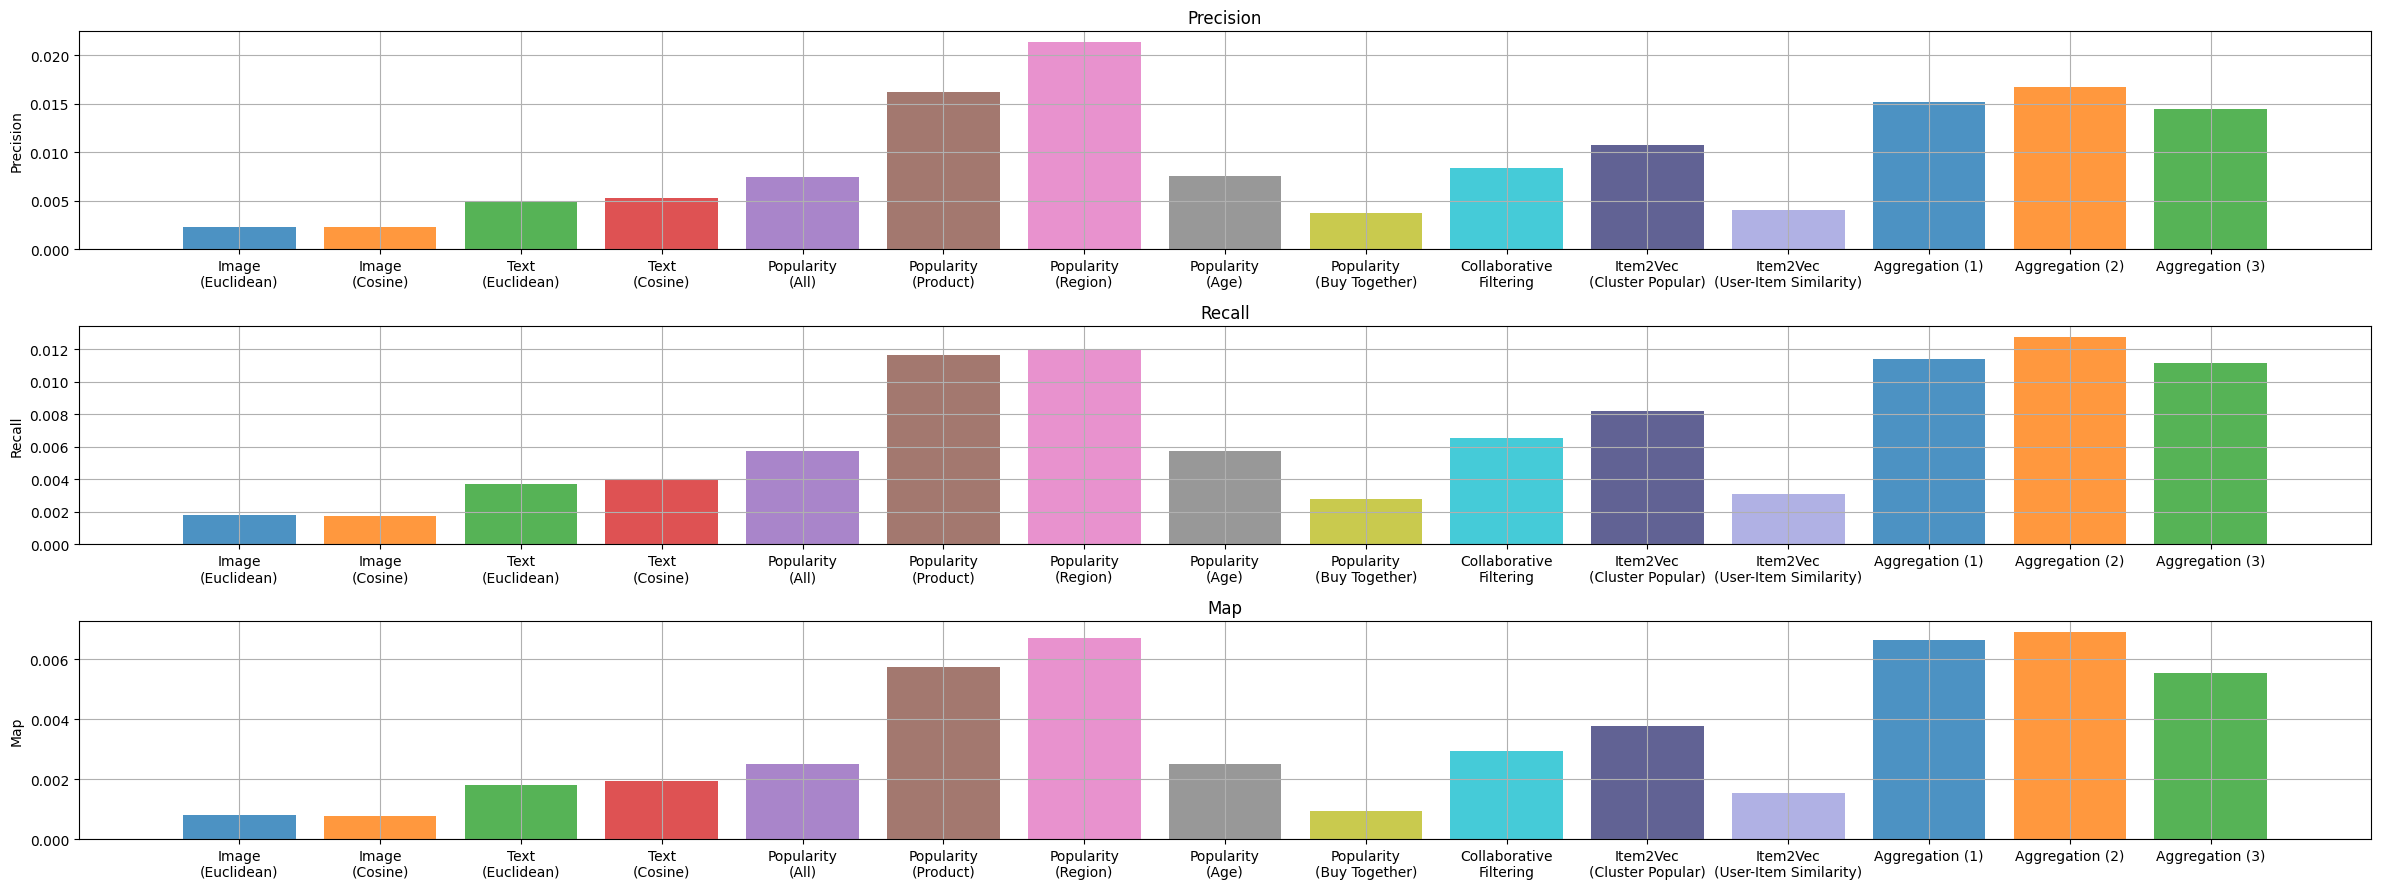

In [19]:
visualize_compare_recommendations(all_user_mean.transpose().to_dict(), metrics=['precision', 'recall', 'map'])

#### **Q2: What methods are better when users have different number of purchase history?**

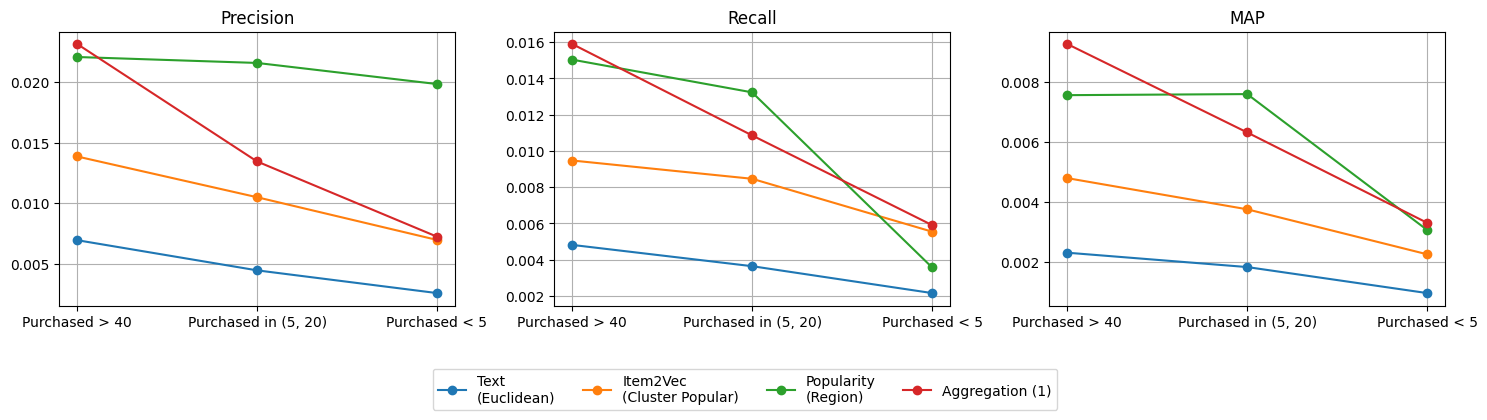

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Define the rows and dataframes
rows_to_plot = [
    "Text\n(Euclidean)",
    "Item2Vec\n(Cluster Popular)",
    "Popularity\n(Region)",
    "Aggregation (1)"
]
dfs = [loyal_user_mean, regular_user_mean, few_purch_user_mean]
df_names = ['Purchased > 40', 'Purchased in (5, 20)', 'Purchased < 5']  # More readable names for the plot

# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.5))

# Titles for subplots
metrics = ['precision', 'recall', 'map']
titles = ['Precision', 'Recall', 'MAP']

# Plot data
for i, metric in enumerate(metrics):
    for row in rows_to_plot:
        values = [df.loc[row, metric] for df in dfs]  # Collect metric across all dataframes
        axes[i].plot(df_names, values, marker='o', label=row)
    axes[i].set_title(titles[i])
    axes[i].set_xticks(np.arange(len(df_names)))
    axes[i].set_xticklabels(df_names)
    axes[i].grid(True)
    
# Adding a single legend for the whole figure below the subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=7)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.0, 1, 1])

# Show plot
plt.show()


#### **Q3: Which method is better for recommending items to new users?**

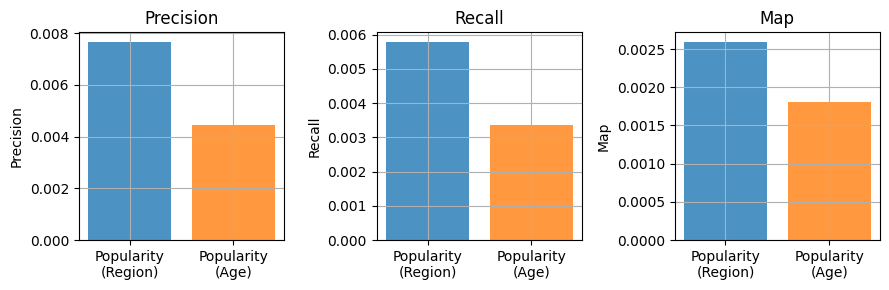

In [21]:
visualize_compare_recommendations(
    new_user_mean.transpose().to_dict(),
    metrics=['precision', 'recall', 'map'],
    fig_width=3,
    vertical=False
)